<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Using Numba to Speed Up Your Model
Author(s): Paul Miles | Date Created: July 19, 2019

This example demonstrates using [pymcmcstat](https://github.com/prmiles/pymcmcstat/wiki) with [Numba](https://numba.pydata.org/), which can be used to compile your model improve computational performance.  We will demonstrate the same problem with and without utilizing [Numba](https://numba.pydata.org/).

In [34]:
import numpy as np
from numba import jit
from pymcmcstat.MCMC import MCMC
import time
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore')

1.9.0


{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

# Define data set
To define our data set, we generate a set of points along the line, $y = 2x - 3$, and add some random noise to the response.  We have plotted the data with and without the random noise added to it.

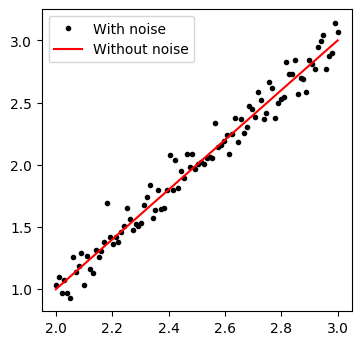

In [35]:
# Define data set
nds = 100
x = np.linspace(2, 3, num=nds)
x = x.reshape(nds, 1)
m = 2 # slope
b = -3 # offset
noise = 0.1*np.random.standard_normal(x.shape)
y = m*x + b + noise

# plot data
plt.figure(dpi=100, figsize=(4, 4))
plt.plot(x, y, '.k', label='With noise');
plt.plot(x, m*x + b, '-r', label='Without noise');
plt.legend();

# Define Numba Model
We define our [Numba](https://numba.pydata.org/) model using the `jit` decorator.

In [37]:
@jit(nopython=True)
def numba_linear_model(q, x):
    m, b = q
    return m*x + b

q = np.array([3., 2.])
start = time.time()
numba_linear_model(q, x)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
numba_linear_model(q, x)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.12098097801208496
Elapsed (after compilation) = 5.173683166503906e-05


# Define Python Model

In [38]:
def py_linear_model(q, x):
    m, b = q
    return m*x + b

# Compare Model Outputs

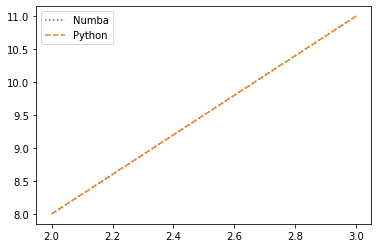

In [39]:
q0 = np.array([3., 2.])
ynumbatest = numba_linear_model(q0, x)
ypytest = py_linear_model(q0, x)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, ynumbatest, ':', label='Numba')
ax.plot(x, ypytest, '--', label='Python')
tmp = ax.legend()

Both models output the same thing!

# Define Sum-of-Squares Function
At this point we can define our sum-of-squares function.  We setup our evaluation such that we can easily compare a Python and Numba implementation.  Note, the model type is inputted to the function by including it in the `user_defined_object` of the `data` structure.

In [40]:
def ssfun(q, data):
    xdata = data.xdata[0]
    ydata = data.ydata[0]
    model_type = data.user_defined_object[0]
    nx = len(xdata)
    if model_type == 'numba':
        # eval model numba model
        ymodel = numba_linear_model(q, xdata).reshape(ydata.shape)
    else:
        ymodel = py_linear_model(q, xdata).reshape(ydata.shape)
    # calc sos
    ss = ((ymodel - ydata)**2).sum()
    return ss

# Setup MCMC Simulation
We can now setup our MCMC simulation as we would for any other problem.  Note, the C++ model has been added to the `data` structure.

In [41]:
model_types = ['py', 'numba']
results = {}
for model_type in model_types:
    print('Running MCMC using model type: {}'.format(model_type))
    # Initialize MCMC object
    mcstat = MCMC()
    # Add data
    mcstat.data.add_data_set(x, y, user_defined_object=model_type)
    # initialize parameter array
    mcstat.parameters.add_model_parameter(
        name='m',
        theta0=1.7,
        minimum=-10,
        maximum=10)
    mcstat.parameters.add_model_parameter(
        name='b',
        theta0=2.5,
        minimum=-10,
        maximum=100)
    # update simulation options
    mcstat.simulation_options.define_simulation_options(
        nsimu=int(10.0e3),
        updatesigma=True,
        method='dram',
        adaptint=100,
        verbosity=1,
        waitbar=True)
    # update model settings
    mcstat.model_settings.define_model_settings(sos_function=ssfun)
    # Run mcmcrun
    mcstat.run_simulation()
    results[model_type] = mcstat.simulation_results.results.copy()
    print('\n')

Running MCMC using model type: py

Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      1.70 [   -10.00,     10.00] N( 0.00e+00,      inf)
         b:      2.50 [   -10.00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 10000 of 10000 complete in 2.3 sec

Running MCMC using model type: numba

Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      1.70 [   -10.00,     10.00] N( 0.00e+00,      inf)
         b:      2.50 [   -10.00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 10000 of 10000 complete in 2.2 sec



The Numba implementation runs slightly faster, but we are dealing with a very simple model.

# Extract Results and Display Chain Statistics/Plots
We take the results of the MCMC simulation, remove the first half of the chain to account for burnin, and perform our analysis on the remaining part of the chain.

Plots:
- Marginal posterior densities
- Sampling chains
- Pairwise correlation

In [70]:
for model_type in model_types:
    print(30*'*')
    print('Results using model type: {}'.format(model_type))
    # Extract results
    result = results[model_type]
    chain = result['chain']
    s2chain = result['s2chain']
    sschain = result['sschain']
    names = result['names']
    # define burnin
    burnin = int(result['nsimu']/2)
    # display chain statistics
    mcstat.chainstats(chain[burnin:,:], result)

******************************
Results using model type: py


------------------------------
name      :       mean        std     MC_err        tau     geweke
m         :     2.0137     0.0335     0.0023    23.2615     0.9888
b         :    -3.0263     0.0844     0.0057    22.9083     0.9822
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 0.69%
Stage 2: 5.74%
Net    : 6.43% -> 643/10000
---------------
Chain provided:
Net    : 7.46% -> 373/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------
******************************
Results using model type: cpp


------------------------------
name      :       mean        std     MC_err        tau     geweke
m         :     2.0128     0.0320     0.0021    25.2899     0.9993
b         :    -3.0253     0.0805     0.0052    24.5392 

Both approaches yield similar statistics and acceptance rates.

******************************
Results using model type: py
******************************
Results using model type: cpp


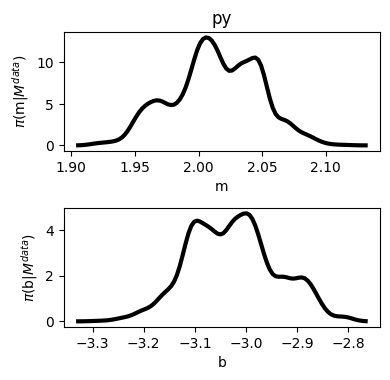

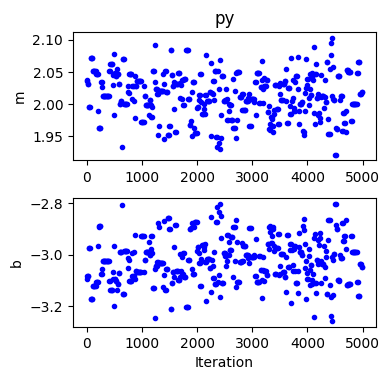

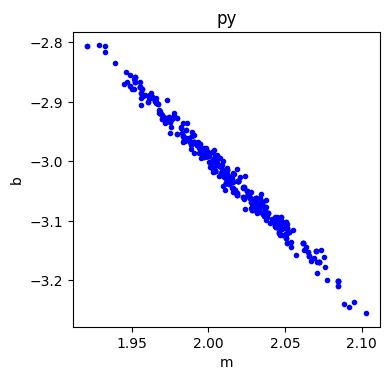

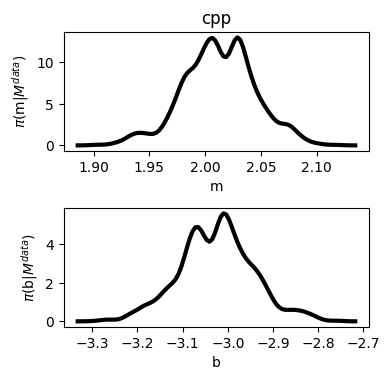

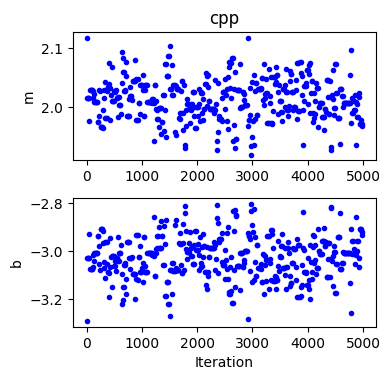

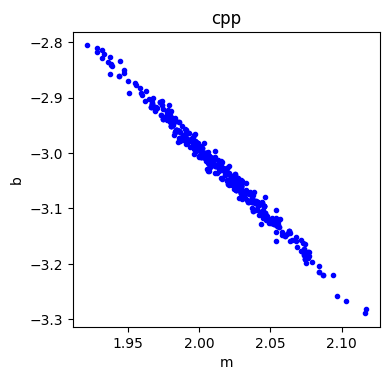

In [71]:
from pymcmcstat import mcmcplot as mcp
# generate mcmc plots
settings = dict(
    fig=dict(figsize=(4,4)))
for model_type in model_types:
    print(30*'*')
    print('Results using model type: {}'.format(model_type))
    # Extract results
    result = results[model_type]
    chain = result['chain']
    s2chain = result['s2chain']
    sschain = result['sschain']
    names = result['names']
    # define burnin
    burnin = int(result['nsimu']/2)
    # plot density panel
    f = mcp.plot_density_panel(chain[burnin:, :], names,
                            settings=settings)
    ax = f.axes[0]
    ax.set_title(model_type)
    # plot chain panel
    f= mcp.plot_chain_panel(chain[burnin:, :], names,
                          settings=settings)
    ax = f.axes[0]
    ax.set_title(model_type)
    # plot pairwise correlation panel
    f = mcp.plot_pairwise_correlation_panel(chain[burnin:, :], names,
                                         settings=settings)
    ax = f.axes[0]
    ax.set_title(model_type)

# Generate/Plot Prediction Intervals
The C++ model can also be used in generating credible/prediction intervals.

Generating credible/prediction intervals:


Interval generation complete



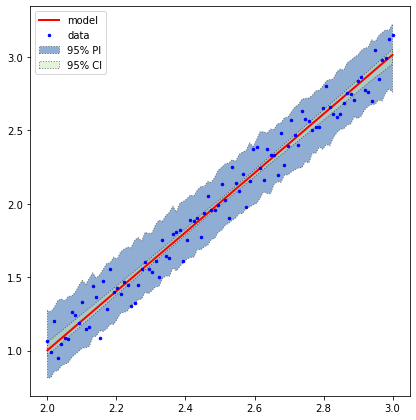

In [74]:
# generate prediction intervals
def pred_modelfun(preddata, theta):
    return cpplm(theta[0], theta[1], preddata.xdata[0], nds).reshape(nds,)
mcstat.PI.setup_prediction_interval_calculation(
    results=results['cpp'],
    data=mcstat.data,
    modelfunction=pred_modelfun)
mcstat.PI.generate_prediction_intervals()
mcstat.PI.plot_prediction_intervals(adddata=True, figsizeinches=(6, 6));